### Filter lateral genes Bmp4 KO vs WT prior to differential expression analysis

In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("tglkmeans")
library("tgstat")
library("Matrix")
library("dplyr")
library("data.table")
library(ggplot2)
library(ggrepel)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last




In [3]:
scdb_init("scrna_db_mm10_star/",force_reinit = T)

initializing scdb to scrna_db_mm10_star/



In [4]:
mc_atlas = scdb_mc("mm_embexe")
mat_atlas = scdb_mat("mm_embexe")
mat_bmp4_ko = scdb_mat("bmp4_ko")
mc_bmp4_ko = scdb_mc("bmp4_ko")

In [9]:
# This object contains the cell type annotation of Bmp4 KO cells
cmp_cell_type_annotation = readRDS('data/cmp_annot_embexe_bmp4.RData')

In [6]:
table(mat_bmp4_ko@cell_metadata[names(mc_bmp4_ko@mc),"cell_genotype"])


  Bmp4 Emb unclear        Bmp4 Emb-KO           Bmp4 gKO Control Tetraploid 
              1482               7903               2816               1654 
       WT/Het Bmp4      empty/ignored 
              3026               1792 

In [8]:
atlas_projection_weights = fread('mc2/bmp4_ko.query.atlas.weights.csv')
atlas_projection_weights$query = as.integer(atlas_projection_weights$query +1)
atlas_projection_weights$atlas = as.integer(atlas_projection_weights$atlas + 1)
atlas_projection_weights = as.data.frame(atlas_projection_weights)

In [10]:
query_atlas_proj_mat = sparseMatrix(i = atlas_projection_weights$query,
                                    j = atlas_projection_weights$atlas,
                                    x = atlas_projection_weights$weight)

In [11]:
min(rowSums(query_atlas_proj_mat))
max(rowSums(query_atlas_proj_mat))

[1] 1

[1] 1

In [17]:
bmp4_tetraploid_ko_cells = names(mc_bmp4_ko@mc)[ mat_bmp4_ko@cell_metadata[names(mc_bmp4_ko@mc),"cell_genotype"] == "Bmp4 Emb-KO"]
bmp4_germline_ko_cells = names(mc_bmp4_ko@mc)[ mat_bmp4_ko@cell_metadata[names(mc_bmp4_ko@mc),"cell_genotype"] == "Bmp4 gKO"]
bmp4_germline_control_cells = names(mc_bmp4_ko@mc)[ mat_bmp4_ko@cell_metadata[names(mc_bmp4_ko@mc),"cell_genotype"] == "WT/Het Bmp4"]
bmp4_tetraploid_control_cells = names(mc_bmp4_ko@mc)[ mat_bmp4_ko@cell_metadata[names(mc_bmp4_ko@mc),"cell_genotype"] == "Control Tetraploid"]
query_cells_all = c(bmp4_tetraploid_ko_cells,bmp4_tetraploid_control_cells,bmp4_germline_ko_cells,bmp4_germline_control_cells)
query_cells_all = intersect(query_cells_all,names(cmp_cell_type_annotation$query_cls_col))

In [18]:
# Compute bulk expression per wildtype metacell
egc_wt = t(tgs_matrix_tapply(x = mat_atlas@mat[,names(mc_atlas@mc)],mc_atlas@mc,sum))
egc_wt = t(t(egc_wt)/colSums(egc_wt))

In [19]:
# For each query metacell (consisting of Bmp4 KO cells) we compute the best matching wildtype profile
# query_atlas_proj_mat has dimension number_of_query_metacells x number_of_atlas_metacells
# each row sums up to 1 and encodes the linear combination of atlas metacells 
# that are the best matching profile of the query metacell

reg = 5e-5
legc_ref = log2(egc_wt %*% t(query_atlas_proj_mat) +reg)
colnames(legc_ref) = c(1:ncol(legc_ref))

In [20]:
col_to_ct = mc_bmp4_ko@color_key$group
names(col_to_ct) = mc_bmp4_ko@color_key$color

In [21]:
mc_bmp4_ko@color_key

,group,color
,<chr>,<chr>
1,Forebrain/Midbrain/Hindbrain,#647A4F
2,Rostral neural plate,#649146
3,Surface ectoderm,#f7f79e
4,Neural crest,#C3C388
5,Caudal neural plate,#354E23
6,Neural tube/Floor plate,#CDE088
7,Neural plate boundary,#879E86
71,Definitive ectoderm,#90BF75
8,Tail bud - neural,#8e7e59


In [22]:
min_cells_per_cell_type = 40
# only include embryonic cell types
included_cell_types = mc_bmp4_ko@color_key$group[1:39]

cell_list_per_genotype = tapply(query_cells_all,mat_bmp4_ko@cell_metadata[query_cells_all,"cell_genotype"],function(query_cells) {
    
    n_cells_per_cell_type = table(factor(x = col_to_ct[ cmp_cell_type_annotation$query_cls_col[query_cells]],levels = mc_bmp4_ko@color_key$group))
    
    cell_type_f = names(n_cells_per_cell_type)[(n_cells_per_cell_type >= min_cells_per_cell_type)]
    cell_type_f = intersect(cell_type_f,included_cell_types)
    
    query_cells_f = query_cells[ col_to_ct[ cmp_cell_type_annotation$query_cls_col[query_cells]] %in%cell_type_f]
    return(query_cells_f)
})

### Compute bulk profiles per cell type for query cells (germline/tetraploid KO, controls) and best matching wildtype profile

In [23]:
# bulk profiles per cell type for query cells
legc_per_ct = lapply(cell_list_per_genotype,function(cells) {
    
    egc_q = t(tgs_matrix_tapply(mat_bmp4_ko@mat[,cells],col_to_ct[ cmp_cell_type_annotation$query_cls_col[cells]],sum))
    egc_q = t(t(egc_q)/colSums(egc_q))
    
    return(log2(egc_q + reg))
})

In [25]:
legc_per_ct_ref = lapply(cell_list_per_genotype,function(cells) {
    
    legc_ct = t(tgs_matrix_tapply(as.matrix(legc_ref[ ,as.character(mc_bmp4_ko@mc[cells])]),col_to_ct[ cmp_cell_type_annotation$query_cls_col[cells]],mean))
    
    return(legc_ct)
})

In [26]:
# cell type and genotype annotations for pheatmap
cell_type_annotation_list = lapply(legc_per_ct,function(x) {return(colnames(x))})

genotype_annotation = rep(names(sapply(cell_type_annotation_list,length)),times = sapply(cell_type_annotation_list,length))
cell_type_annotation_list = do.call(c,cell_type_annotation_list)


In [27]:
legc_all_per_ct = do.call(cbind,legc_per_ct)
legc_all_per_ct_ref= do.call(cbind,legc_per_ct_ref)
# log fold change between query and WT profiles
lfc_all_ct = do.call(cbind,legc_per_ct) - do.call(cbind,legc_per_ct_ref)
colnames(lfc_all_ct) = c(1:ncol(lfc_all_ct))

In [33]:
# Filter genes based on minimal_expression_threshold and minimal min_max_difference 
minimal_expression_threshold = -13
minimal_min_max_difference = 0.8 


f_min_ct = apply(cbind(do.call(cbind,legc_per_ct),do.call(cbind,legc_per_ct_ref)),1,max) > minimal_expression_threshold
f_var_ct = apply(abs(lfc_all_ct),1,max) > minimal_min_max_difference
sum(f_var_ct & f_min_ct)
sum(f_var_ct)
genes_f = rownames(lfc_all_ct)[f_var_ct & f_min_ct]

# cluster selected genes using kmeans on log fold changes 
number_of_clusters = 10

kmeans_genes = tglkmeans::TGL_kmeans(df = lfc_all_ct[genes_f,],k = number_of_clusters,id_column = F,seed = 123)
names(kmeans_genes$cluster) = genes_f

[1] 498

[1] 508

In [34]:
# setting parameters for pheatmap

ct_to_col = mc_bmp4_ko@color_key$color
names(ct_to_col) = mc_bmp4_ko@color_key$group

genotype_to_color = c("Bmp4 Emb-KO" = "red",
                      "Bmp4 gKO" = "cornflowerblue",
                                        "Control Tetraploid" = "orange",
                                        "WT/Het Bmp4" = "gray")
annotation_colors = list(cell_type = ct_to_col,
                         cell_genotype = genotype_to_color)

shades = rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_egc = colorRampPalette(RColorBrewer::brewer.pal(9,name = "BuPu"))(100)
breaks = seq(-2,2,length.out = 101)
breaks_egc = seq(log2(1e-5),-9,length.out = 101)


annotation_cell_type = data.frame(cell_type = cell_type_annotation_list,
                                  cell_genotype = genotype_annotation)
rownames(annotation_cell_type) = 1:nrow(annotation_cell_type)

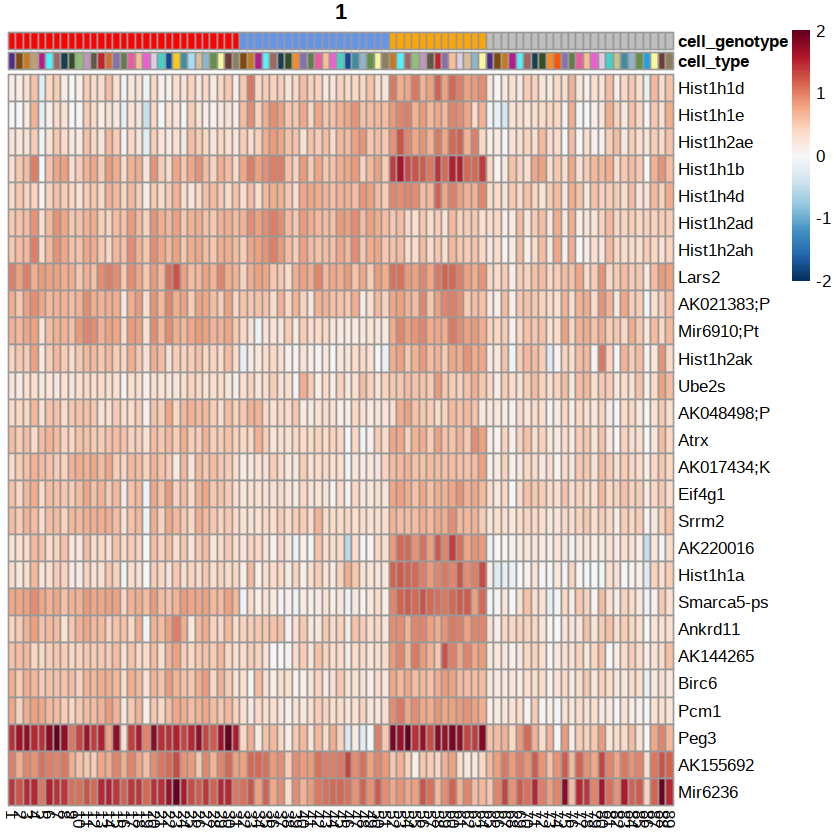

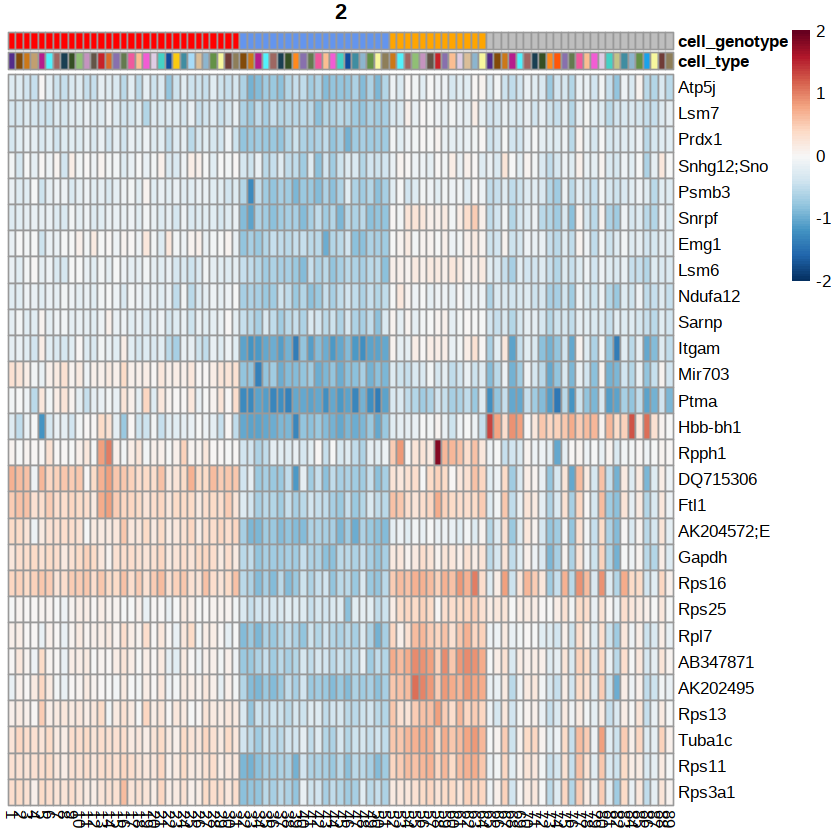

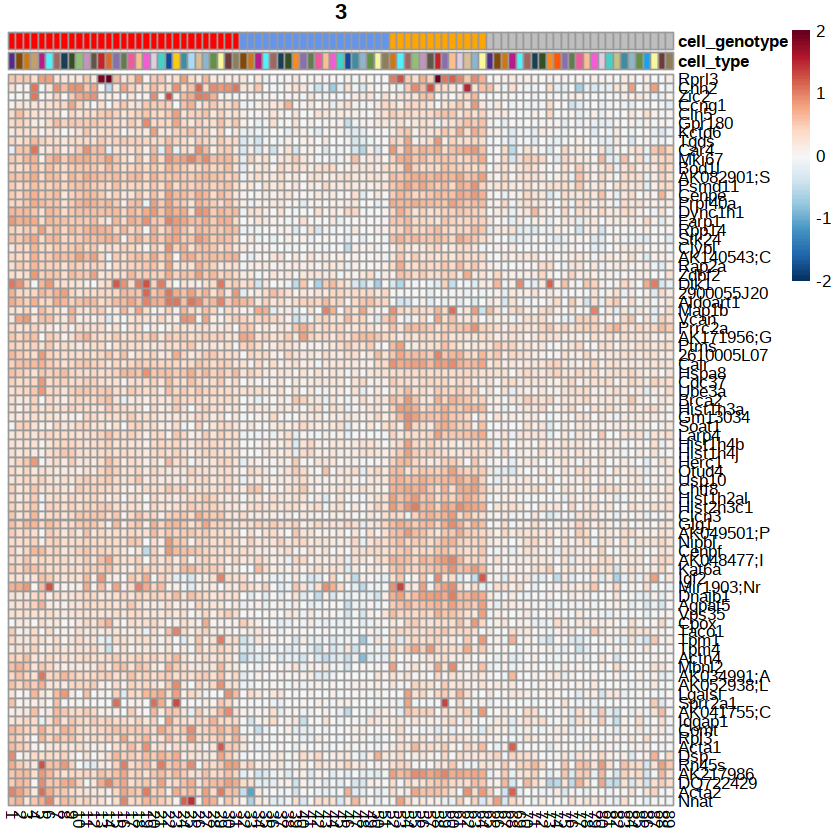

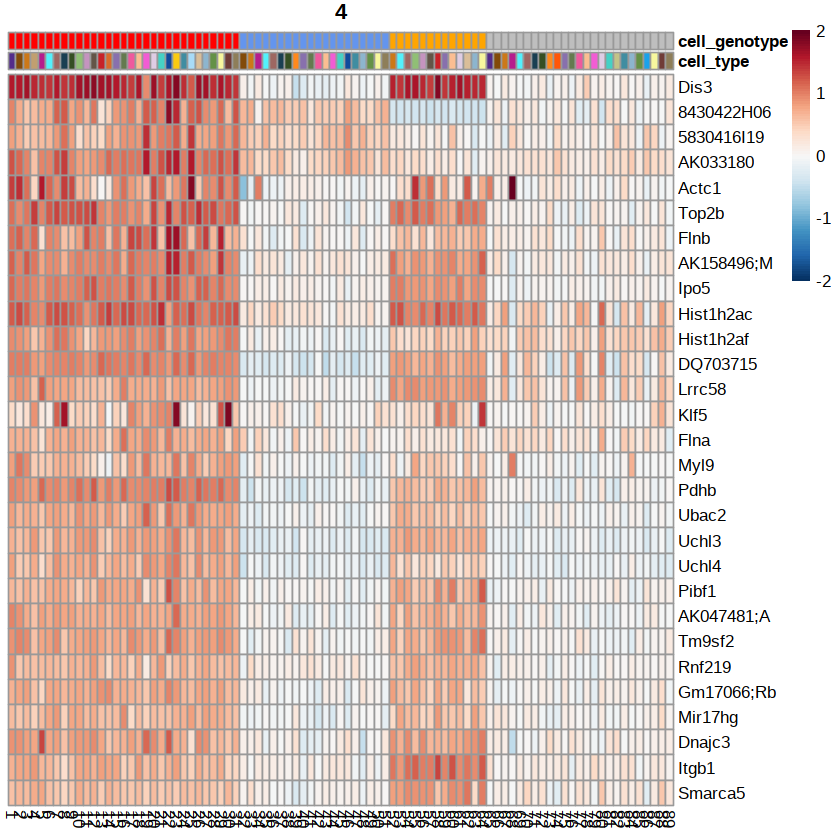

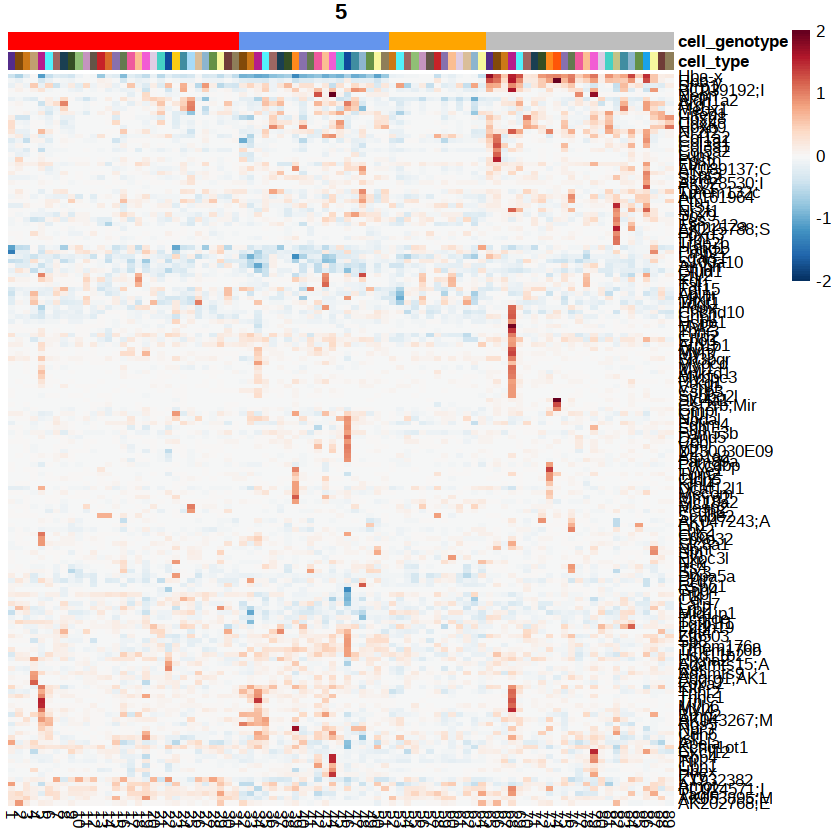

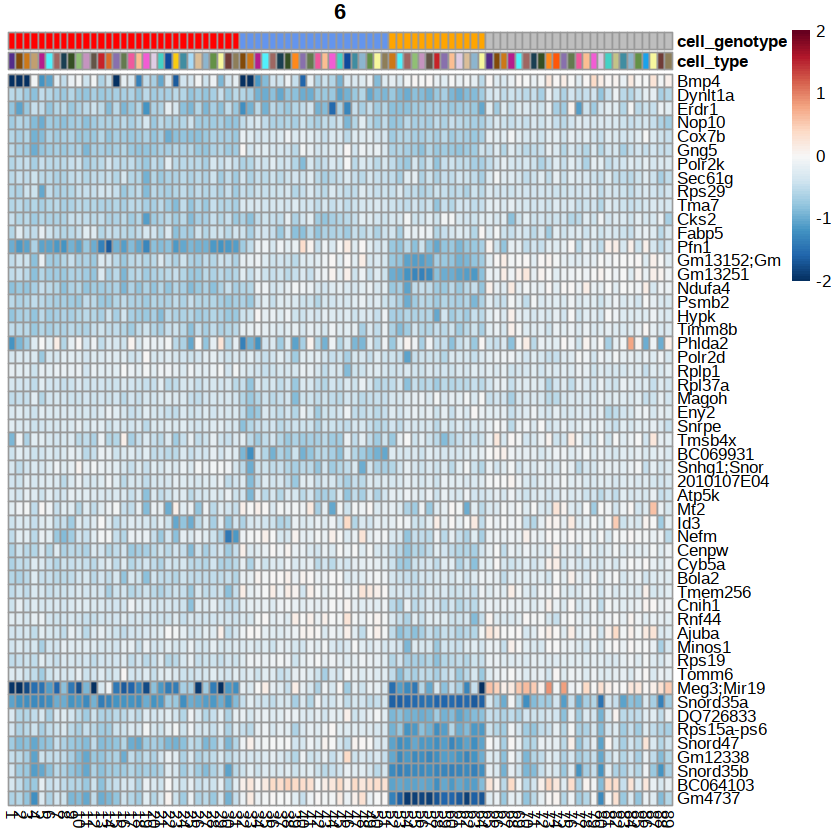

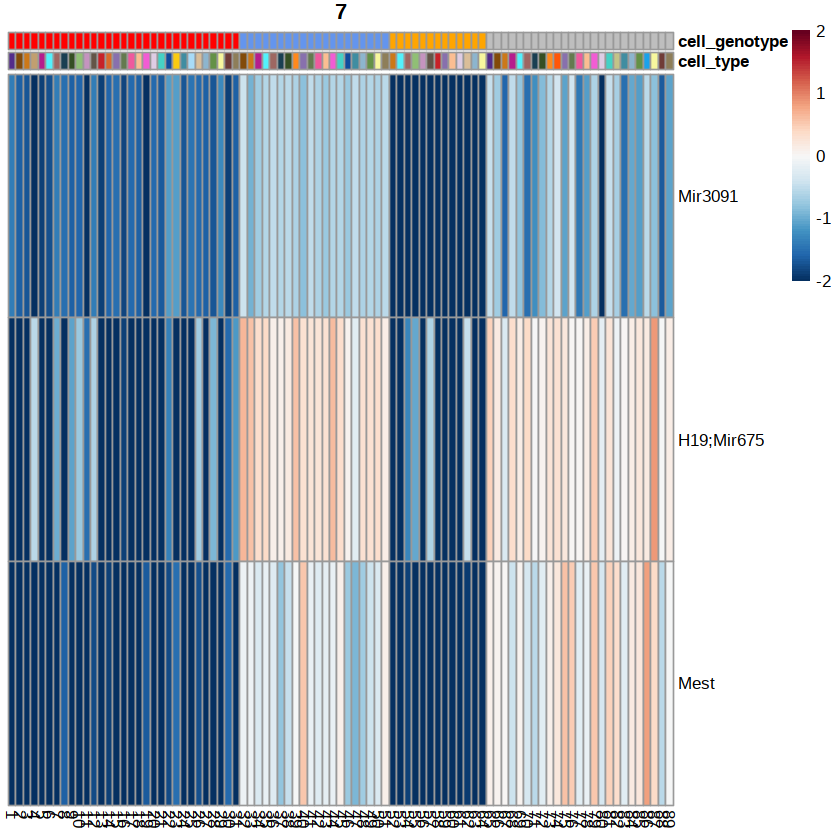

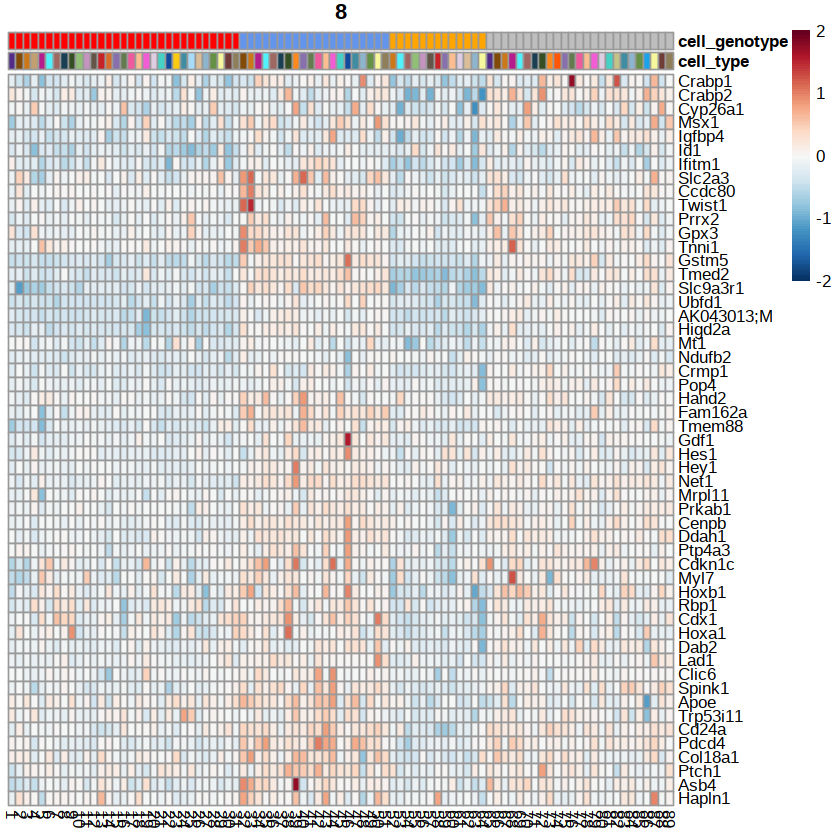

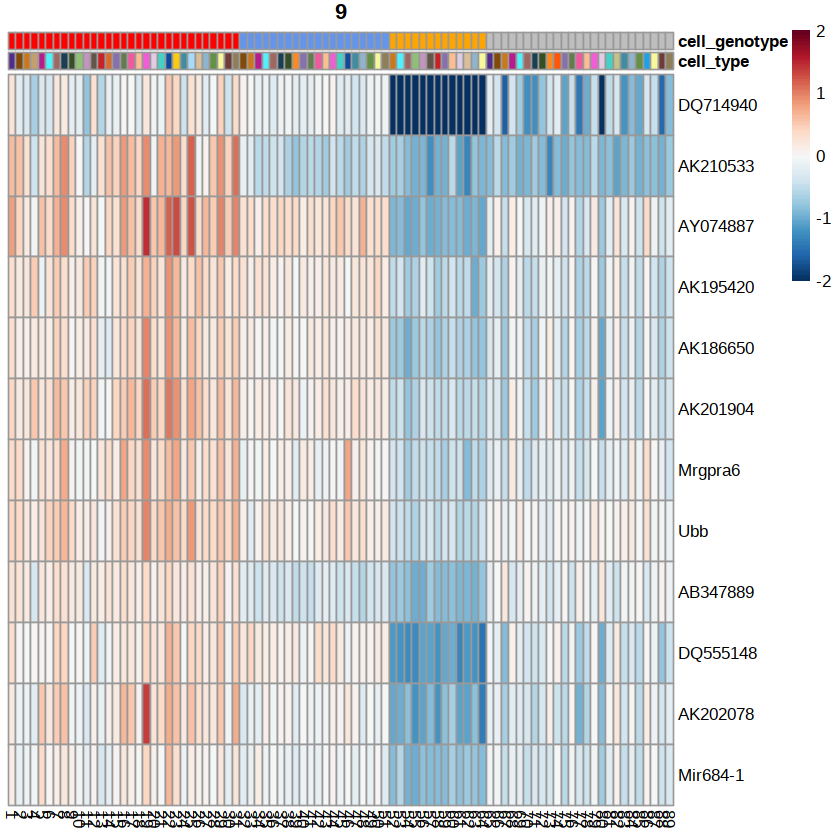

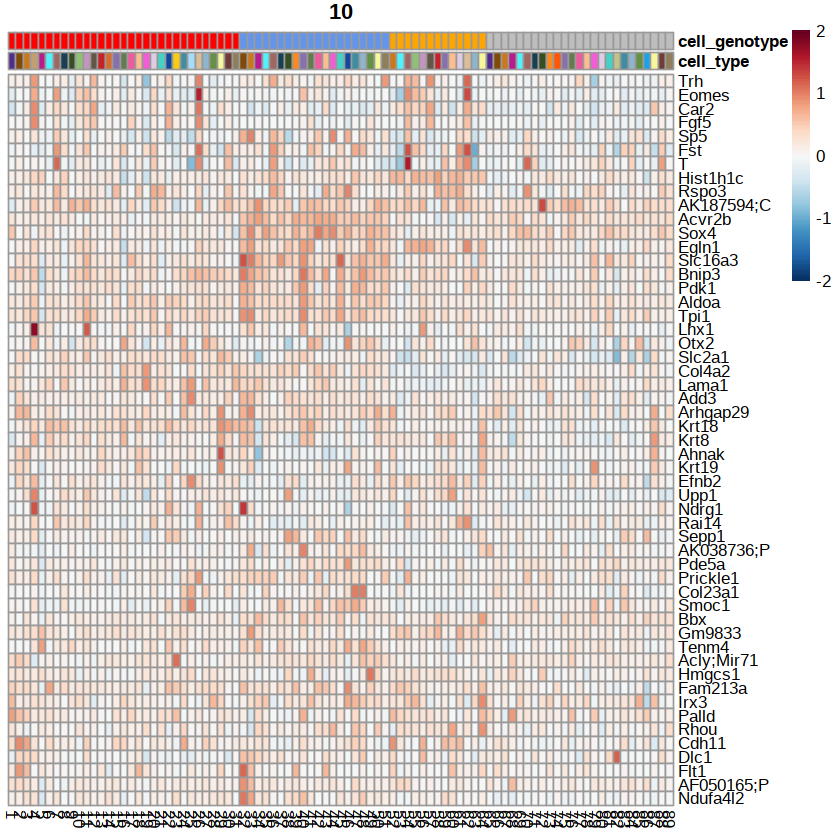

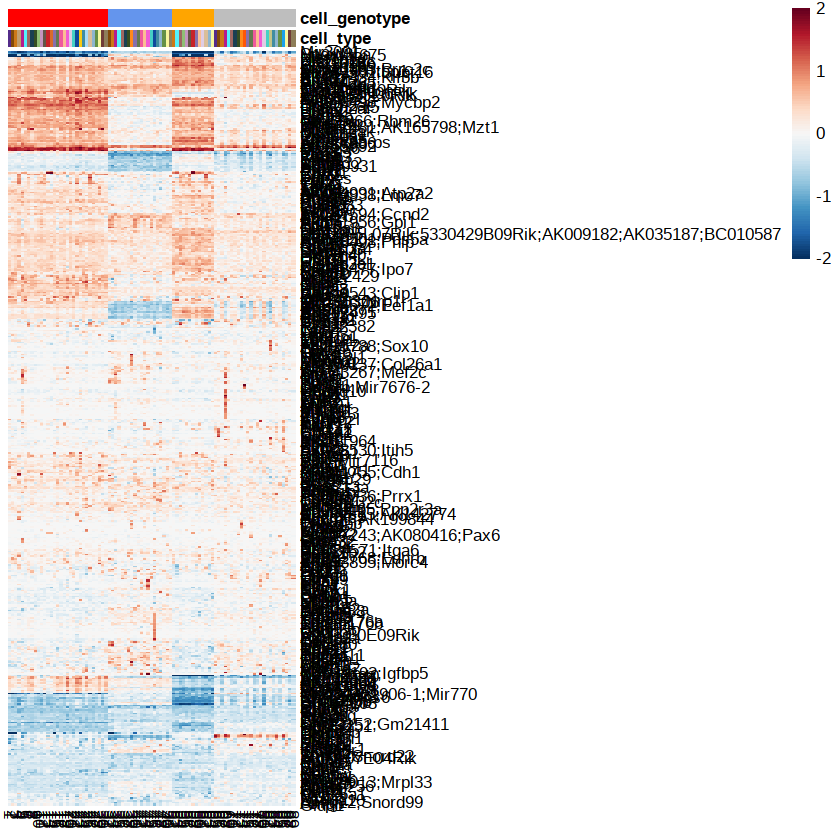

In [36]:
for (cl in 1:number_of_clusters) {
    
    f = kmeans_genes$cluster == cl    
    lfc_f = lfc_all_ct[genes_f[f],]
    rownames(lfc_f) = substr(x = rownames(lfc_f),start = 1,stop = 10)
    
    pheatmap::pheatmap(mat = pmax(pmin(lfc_f,3),-3),color = shades,breaks = breaks,annotation_col = annotation_cell_type,annotation_colors = annotation_colors,cluster_cols = F,treeheight_row = 0,annotation_legend = F,main = cl)

    
    
}

pheatmap::pheatmap(mat = pmax(pmin(lfc_all_ct[genes_f,],3),-3),color = shades,breaks = breaks,annotation_col = annotation_cell_type,annotation_colors = annotation_colors,cluster_cols = F,treeheight_row = 0,annotation_legend = F)
    

In [37]:
additional_lateral_genes = names(kmeans_genes$cluster)[kmeans_genes$cluster %in% c(1,2,3,4,6,7,9)]
additional_lateral_genes = setdiff(additional_lateral_genes,c("Bmp4"))

In [38]:
lateral_genes = read.csv('mc2/embexe_bmp4_og2.lateral_gene_names.csv')
lateral_genes = lateral_genes$gene
lateral_genes_all = union(lateral_genes,additional_lateral_genes)
#lateral_genes_all = union(lateral_genes_all,c("Acta2","Actc1","Myl9"))
#lateral_genes = union(lateral_genes,c('Peg3','H19;Mir675','Meg3;Mir1906-1;Mir770','Phlda2'))

In [69]:
write.table(file = 'data/bmp4_ko_expression_analysis_bad_genes.tsv',x = lateral_genes_all,sep = '\t')